# 🌟 Advanced Park Analytics System
## Enterprise-Grade Park Visitation Analysis Platform

### Project Overview:
This comprehensive analytics system analyzes park visitation patterns using advanced machine learning and data analysis techniques.

### Key Components:
1. 🔄 Data Engineering & Preprocessing
2. 📊 Exploratory Data Analysis
3. 🗺️ Geospatial Analysis
4. 👥 User Behavior Analytics
5. 🤖 Machine Learning Models
6. 📈 Pattern Recognition
7. 🔮 Predictive Analytics
8. 📊 Interactive Visualizations

### Technologies Used:
- Data Processing: Pandas, NumPy
- Machine Learning: Scikit-learn, TensorFlow
- Visualization: Plotly, Seaborn, Folium
- Statistical Analysis: StatsModels
- Geographic Analysis: GeoPy


In [1]:
# Install Required Packages
!pip install pandas numpy scikit-learn tensorflow plotly folium statsmodels geopy prophet mlxtend category_encoders seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 546.4 kB/s eta 0:00:00


In [52]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing, cluster, ensemble, metrics, model_selection
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots  # Add this line
import folium
from folium import plugins
import statsmodels.api as sm
from prophet import Prophet
from geopy.distance import geodesic
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
sns.set_theme()

In [53]:
# System Configuration
class SystemConfig:
    """System configuration and parameters"""
    def __init__(self):
        # Analysis parameters
        self.RANDOM_STATE = 42
        self.TEST_SIZE = 0.2
        self.N_SPLITS = 5

        # Model parameters
        self.N_CLUSTERS = 5
        self.DBSCAN_EPS = 0.3
        self.MIN_SAMPLES = 5

        # Feature engineering parameters
        self.TIME_FEATURES = ['hour', 'day', 'month', 'year', 'weekday']
        self.SPATIAL_FEATURES = ['latitude', 'longitude']
        self.USER_FEATURES = ['visit_count', 'avg_duration', 'unique_parks']

        # Visualization parameters
        self.COLORS = px.colors.qualitative.Set3
        self.MAP_ZOOM = 12

config = SystemConfig()

In [54]:
# First upload the file
from google.colab import files
uploaded = files.upload()

class DataProcessor:
    """Process and enhance the dataset"""
    def __init__(self, df):
        self.df = df
        self.config = SystemConfig()

    def process_data(self):
        """Complete data processing pipeline"""
        self.add_time_features()
        self.add_duration_features()
        self.add_user_features()
        self.add_location_features()
        return self.df

    def add_time_features(self):
        """Add temporal features"""
        self.df['hour'] = self.df['start_time'].dt.hour
        self.df['day'] = self.df['start_time'].dt.day
        self.df['month'] = self.df['start_time'].dt.month
        self.df['year'] = self.df['start_time'].dt.year
        self.df['weekday'] = self.df['start_time'].dt.weekday
        self.df['is_weekend'] = self.df['weekday'].isin([5, 6])
        self.df['day_name'] = self.df['start_time'].dt.day_name()
        self.df['month_name'] = self.df['start_time'].dt.month_name()

    def add_duration_features(self):
        """Calculate visit duration features"""
        self.df['duration'] = (self.df['end_time'] - self.df['start_time']).dt.total_seconds() / 3600
        self.df['duration_category'] = pd.qcut(self.df['duration'],
                                             q=4,
                                             labels=['Short', 'Medium', 'Long', 'Extended'])

    def add_user_features(self):
        """Add user-related features"""
        user_stats = self.df.groupby('user_id').agg({
            'park_name': ['count', 'nunique'],
            'duration': 'mean'
        }).round(2)

        user_stats.columns = ['visit_count', 'unique_parks', 'avg_duration']
        self.df = self.df.merge(user_stats, left_on='user_id', right_index=True)

    def add_location_features(self):
        """Add location-based features"""
        # Calculate distance from city center for rows with valid coordinates
        self.df['distance_to_center'] = np.nan
        valid_coords = self.df[self.df['latitude'].notna() & self.df['longitude'].notna()]
        if len(valid_coords) > 0:
            city_center = (valid_coords['latitude'].mean(), valid_coords['longitude'].mean())
            self.df.loc[valid_coords.index, 'distance_to_center'] = valid_coords.apply(
                lambda row: geodesic(city_center, (row['latitude'], row['longitude'])).km
                if pd.notna(row['latitude']) and pd.notna(row['longitude'])
                else np.nan,
                axis=1
            )

# Modified DataLoader to use our working code
def load_park_data(file_path):
    """Load and process park visit data"""
    with open(file_path, 'r') as f:
        content = f.read()
        content = content.replace('v(', '').replace('}v', '}')
        records = []

        json_objects = content.split('}\n{')
        for i, obj in enumerate(json_objects):
            if i != 0:
                obj = '{' + obj
            if i != len(json_objects) - 1:
                obj = obj + '}'

            try:
                data = json.loads(obj)
                if '_id' in data:
                    location = data.get('location', {})
                    if not isinstance(location, dict):
                        location = {}

                    record = {
                        'park_name': str(location.get('name', 'Unknown')),
                        'latitude': location.get('latitude'),
                        'longitude': location.get('longitude'),
                        'categories': location.get('category', []),
                        'city': str(location.get('city', 'Unknown')),
                        'user_id': str(data.get('firebaseId', '') or data.get('uid', '')),
                        'start_time': pd.to_datetime(data['start_time'].get('$date')),
                        'end_time': pd.to_datetime(data['end_time'].get('$date'))
                    }
                    records.append(record)
            except:
                continue

    return pd.DataFrame(records)

# Load the data
print("Loading data...")
df = load_park_data('journals_data.json')

# Initialize DataProcessor
processor = DataProcessor(df)
df = processor.process_data()

# Display basic information
print("\n=== Dataset Overview ===")
print(f"Total records: {len(df)}")
print(f"Unique parks: {df['park_name'].nunique()}")
print(f"Unique users: {df['user_id'].nunique()}")
print(f"Date range: {df['start_time'].min()} to {df['end_time'].max()}")

Saving journals_data.json to journals_data (2).json
Loading data...

=== Dataset Overview ===
Total records: 421
Unique parks: 109
Unique users: 50
Date range: 1970-01-01 00:00:00+00:00 to 2024-04-30 01:44:55.644000+00:00


# 📊 Exploratory Data Analysis
This section implements comprehensive data analysis including temporal, spatial, and user behavior patterns.

In [55]:
class ExploratoryAnalysis:
    """Comprehensive exploratory data analysis"""
    def __init__(self, df):
        self.df = df
        self.config = SystemConfig()

    def run_complete_eda(self):
        """Run all EDA analyses"""
        self.temporal_analysis()
        self.location_analysis()
        self.user_analysis()
        self.duration_analysis()

In [56]:
# Add temporal_analysis method to ExploratoryAnalysis
def temporal_analysis(self):
    """Analyze temporal patterns"""
    # Create subplots
    fig = plt.figure(figsize=(20, 15))

    # 1. Hourly distribution
    plt.subplot(3, 2, 1)
    sns.histplot(data=self.df, x='hour', bins=24)
    plt.title('Visits by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Number of Visits')

    # 2. Daily distribution
    plt.subplot(3, 2, 2)
    sns.countplot(data=self.df, x='day_name', order=self.df['day_name'].value_counts().index)
    plt.title('Visits by Day of Week')
    plt.xticks(rotation=45)
    plt.xlabel('Day')
    plt.ylabel('Number of Visits')

    # 3. Monthly distribution
    plt.subplot(3, 2, 3)
    sns.countplot(data=self.df, x='month_name',
                 order=self.df['month_name'].value_counts().index)
    plt.title('Visits by Month')
    plt.xticks(rotation=45)
    plt.xlabel('Month')
    plt.ylabel('Number of Visits')

    # 4. Duration by day
    plt.subplot(3, 2, 4)
    sns.boxplot(data=self.df, x='day_name', y='duration',
               order=self.df['day_name'].value_counts().index)
    plt.title('Visit Duration by Day')
    plt.xticks(rotation=45)
    plt.xlabel('Day')
    plt.ylabel('Duration (hours)')

    # 5. Duration by month
    plt.subplot(3, 2, 5)
    sns.boxplot(data=self.df, x='month_name', y='duration',
               order=self.df['month_name'].value_counts().index)
    plt.title('Visit Duration by Month')
    plt.xticks(rotation=45)
    plt.xlabel('Month')
    plt.ylabel('Duration (hours)')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n=== Temporal Analysis Summary ===")
    print(f"Peak hour: {self.df.groupby('hour')['park_name'].count().idxmax()}")
    print(f"Busiest day: {self.df.groupby('day_name')['park_name'].count().idxmax()}")
    print(f"Busiest month: {self.df.groupby('month_name')['park_name'].count().idxmax()}")

# Add the method to the class
ExploratoryAnalysis.temporal_analysis = temporal_analysis

In [57]:
# Add location_analysis method to ExploratoryAnalysis
def location_analysis(self):
    """Analyze location-based patterns"""
    # Filter out records with missing coordinates
    df_with_coords = self.df.dropna(subset=['latitude', 'longitude'])

    if len(df_with_coords) > 0:
        # Create visualizations
        fig = plt.figure(figsize=(15, 10))

        # 1. Park popularity
        plt.subplot(2, 1, 1)
        park_visits = self.df['park_name'].value_counts()
        sns.barplot(x=park_visits.values[:10], y=park_visits.index[:10])
        plt.title('Top 10 Most Visited Parks')
        plt.xlabel('Number of Visits')

        # 2. Average duration by park
        plt.subplot(2, 1, 2)
        park_duration = self.df.groupby('park_name')['duration'].mean().sort_values(ascending=False)
        sns.barplot(x=park_duration.values[:10], y=park_duration.index[:10])
        plt.title('Average Visit Duration by Park (Top 10)')
        plt.xlabel('Average Duration (hours)')

        plt.tight_layout()
        plt.show()

        # Create a map
        center_lat = df_with_coords['latitude'].mean()
        center_lon = df_with_coords['longitude'].mean()

        m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

        # Add markers for each park
        for idx, row in df_with_coords.drop_duplicates('park_name').iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=8,
                popup=row['park_name'],
                color='red',
                fill=True
            ).add_to(m)

        display(m)

    # Print summary statistics
    print("\n=== Location Analysis Summary ===")
    print(f"Most popular park: {park_visits.index[0]}")
    print(f"Park with longest average visits: {park_duration.index[0]}")

# Add the method to the class
ExploratoryAnalysis.location_analysis = location_analysis

In [58]:
# Add user_analysis method to ExploratoryAnalysis
def user_analysis(self):
    """Analyze user behavior patterns"""
    fig = plt.figure(figsize=(15, 10))

    # 1. Visit frequency distribution
    plt.subplot(2, 2, 1)
    sns.histplot(data=self.df, x='visit_count', bins=30)
    plt.title('Distribution of Visit Frequency')
    plt.xlabel('Number of Visits')

    # 2. Unique parks per user
    plt.subplot(2, 2, 2)
    sns.histplot(data=self.df, x='unique_parks', bins=20)
    plt.title('Number of Unique Parks Visited')
    plt.xlabel('Number of Parks')

    # 3. Average duration per user
    plt.subplot(2, 2, 3)
    sns.histplot(data=self.df, x='avg_duration', bins=30)
    plt.title('Average Visit Duration per User')
    plt.xlabel('Duration (hours)')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n=== User Analysis Summary ===")
    print(f"Average visits per user: {self.df['visit_count'].mean():.2f}")
    print(f"Average parks per user: {self.df['unique_parks'].mean():.2f}")
    print(f"Average visit duration: {self.df['avg_duration'].mean():.2f} hours")

# Add the method to the class
ExploratoryAnalysis.user_analysis = user_analysis

In [59]:
# Add duration_analysis method to ExploratoryAnalysis
def duration_analysis(self):
    """Analyze visit duration patterns"""
    # Remove outliers for visualization
    df_clean = self.df[self.df['duration'] <= self.df['duration'].quantile(0.99)]

    fig = plt.figure(figsize=(15, 10))

    # 1. Duration distribution
    plt.subplot(2, 2, 1)
    sns.histplot(data=df_clean, x='duration', bins=50)
    plt.title('Distribution of Visit Durations')
    plt.xlabel('Duration (hours)')

    # 2. Duration by category
    plt.subplot(2, 2, 2)
    sns.countplot(data=df_clean, x='duration_category')
    plt.title('Visit Duration Categories')
    plt.xlabel('Duration Category')

    # 3. Duration by hour
    plt.subplot(2, 2, 3)
    sns.boxplot(data=df_clean, x='hour', y='duration')
    plt.title('Duration by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Duration (hours)')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n=== Duration Analysis Summary ===")
    print(f"Average duration: {self.df['duration'].mean():.2f} hours")
    print(f"Median duration: {self.df['duration'].median():.2f} hours")
    print(f"Standard deviation: {self.df['duration'].std():.2f} hours")

# Add the method to the class
ExploratoryAnalysis.duration_analysis = duration_analysis

Running Exploratory Data Analysis...


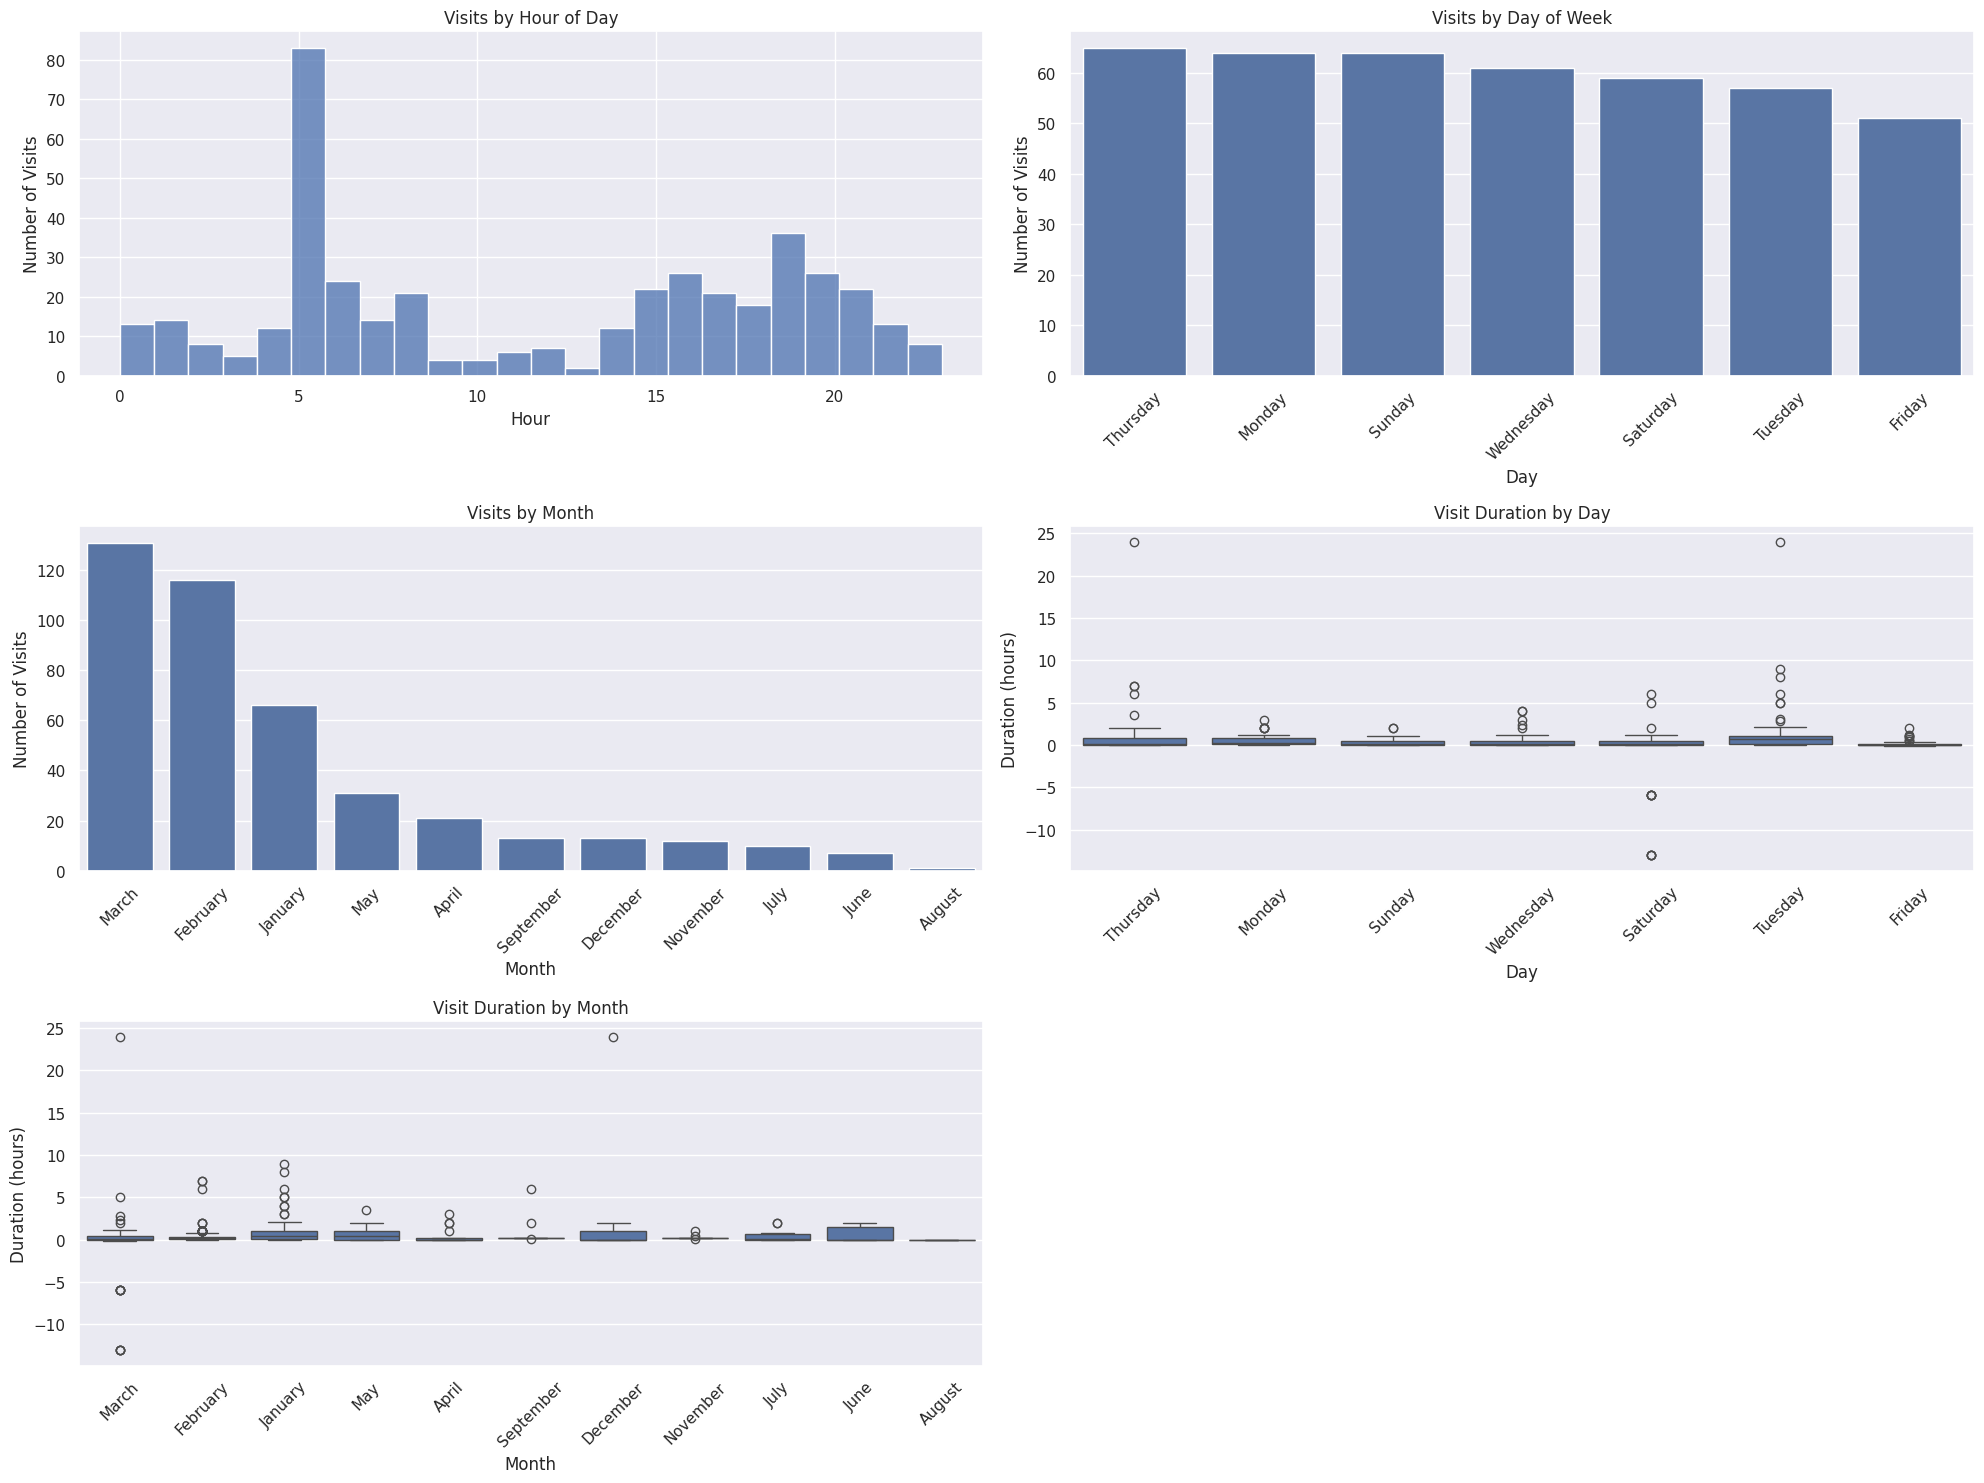


=== Temporal Analysis Summary ===
Peak hour: 5
Busiest day: Thursday
Busiest month: March


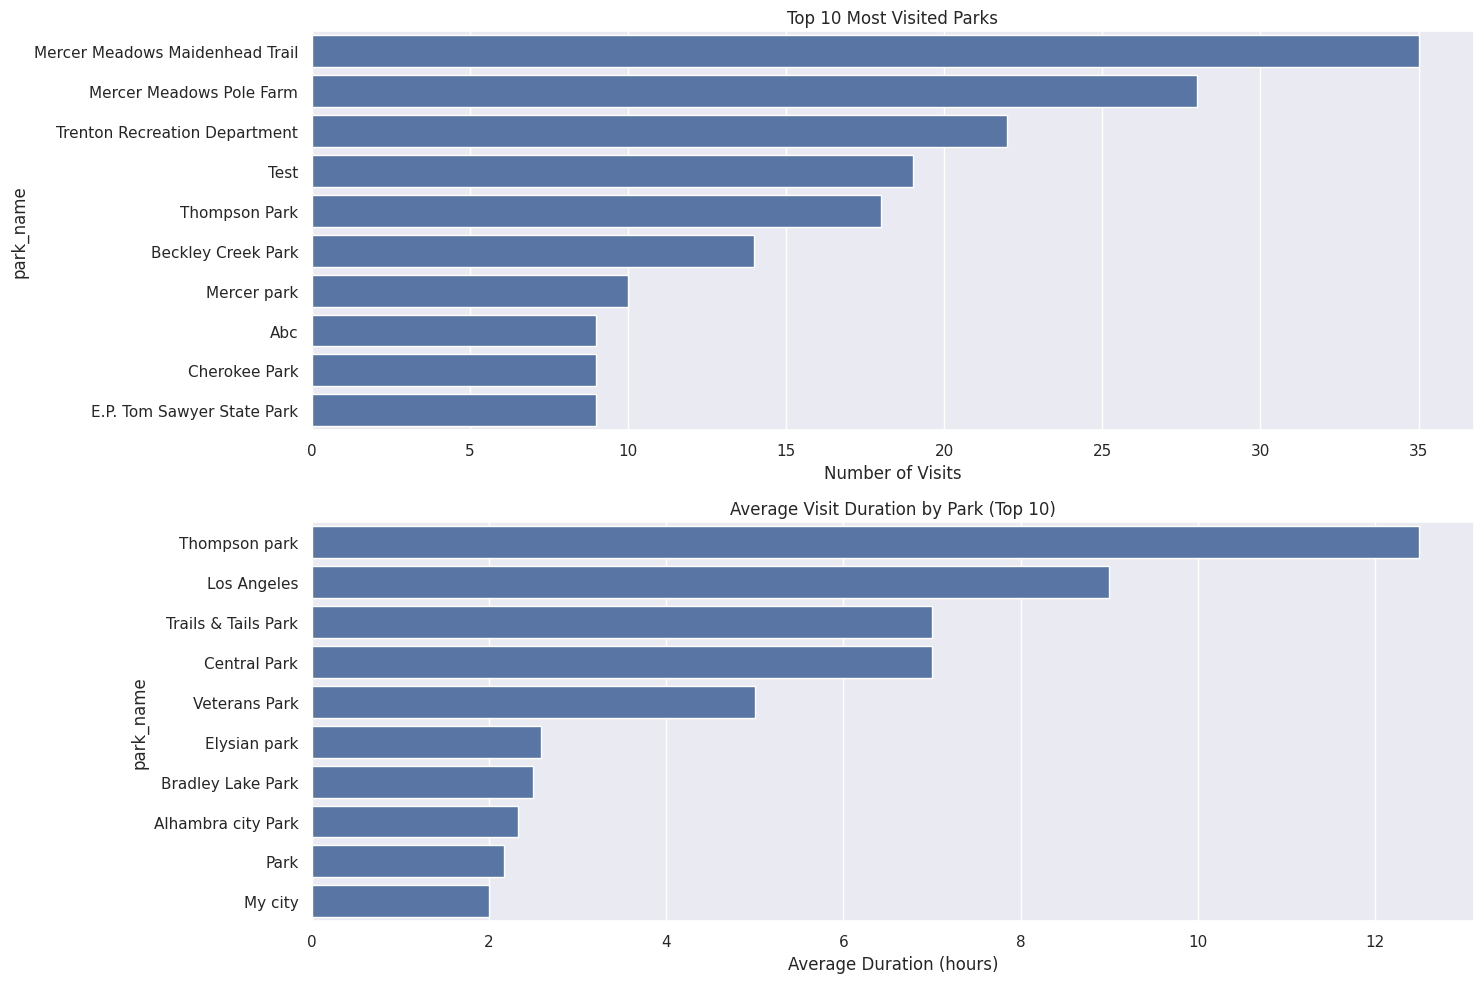


=== Location Analysis Summary ===
Most popular park: Mercer Meadows Maidenhead Trail
Park with longest average visits: Thompson park


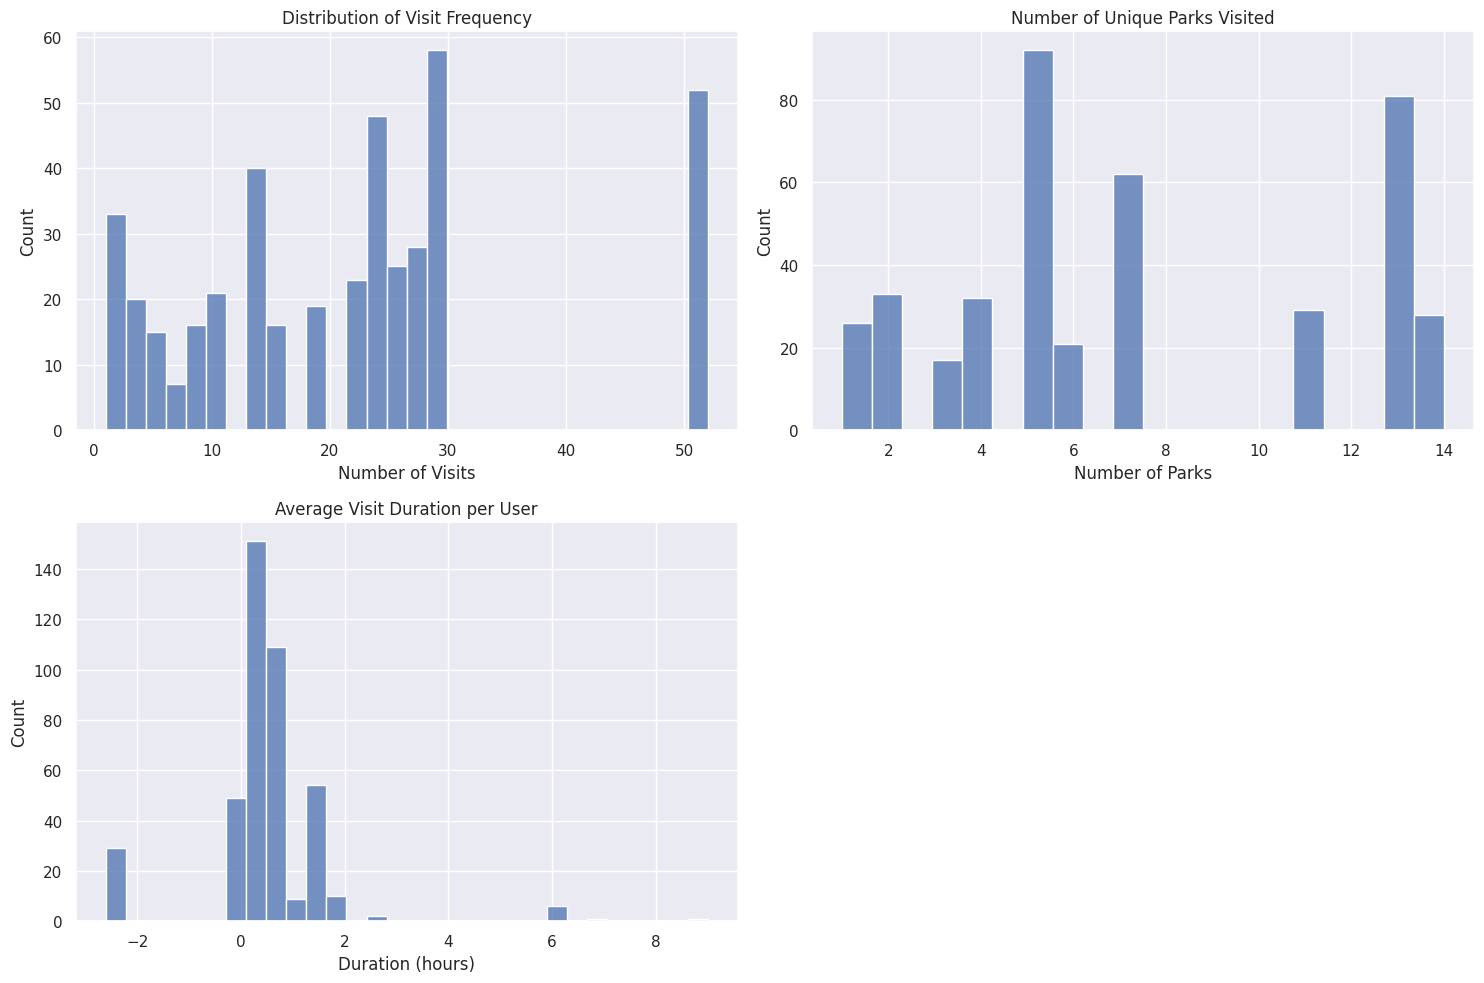


=== User Analysis Summary ===
Average visits per user: 21.90
Average parks per user: 7.26
Average visit duration: 0.47 hours


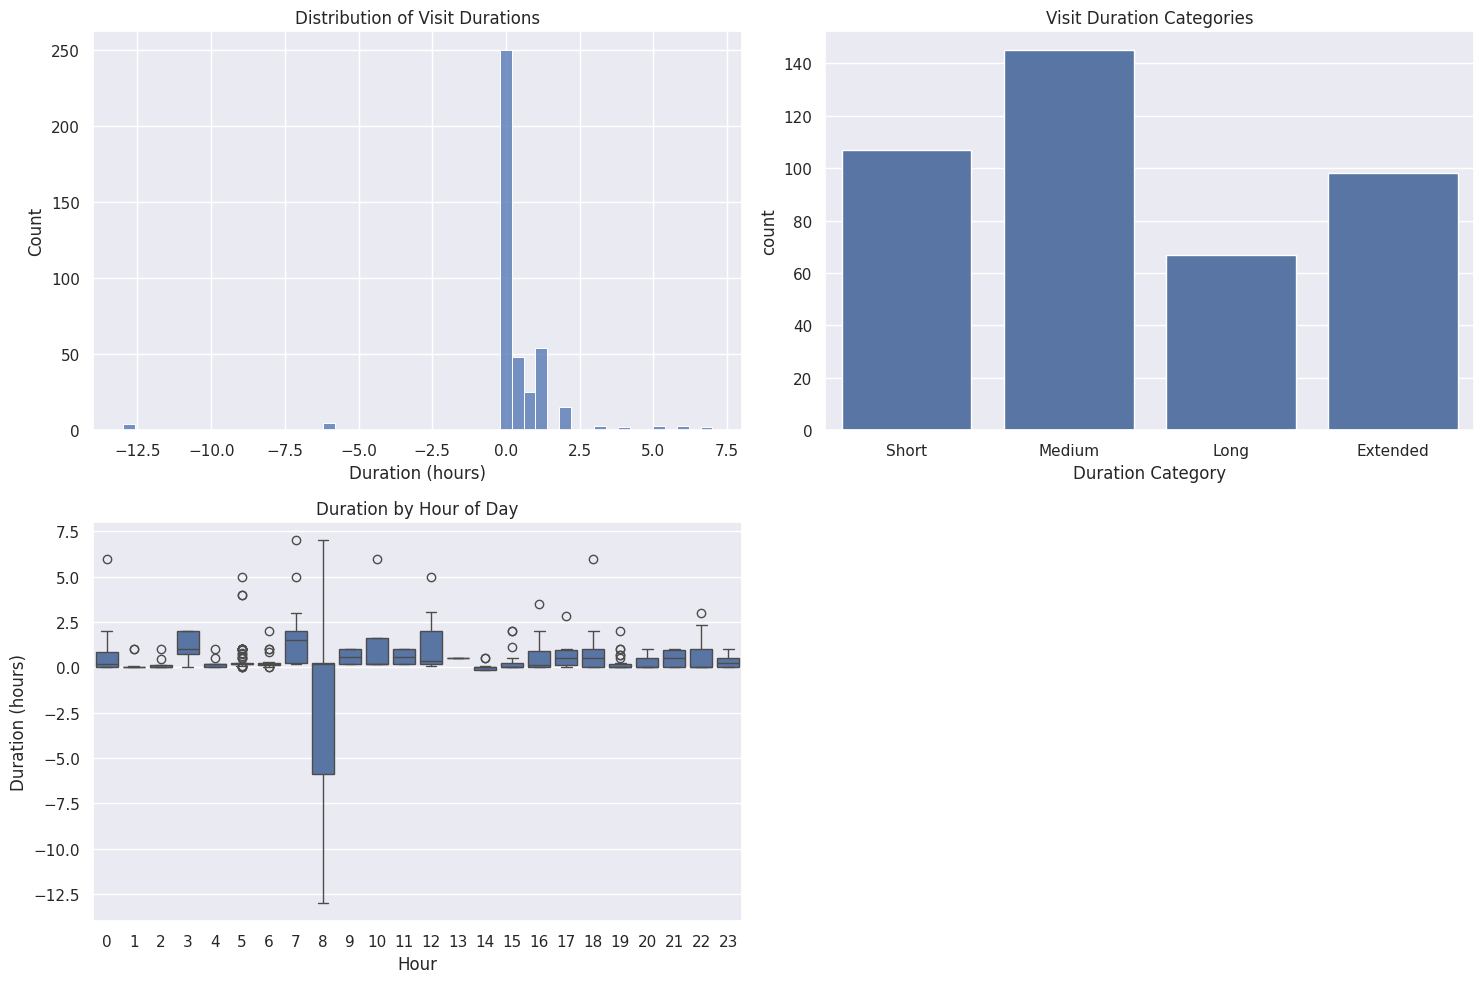


=== Duration Analysis Summary ===
Average duration: 0.47 hours
Median duration: 0.17 hours
Standard deviation: 2.47 hours


In [60]:
# Run the complete EDA
print("Running Exploratory Data Analysis...")
eda = ExploratoryAnalysis(df)
eda.run_complete_eda()

# 🗺️ Spatial Analysis and Pattern Detection
This section implements advanced spatial clustering and pattern recognition techniques.

In [61]:
class SpatialAnalyzer:
    """Advanced spatial analysis and clustering"""
    def __init__(self, df):
        self.df = df
        self.config = SystemConfig()
        self.scaler = preprocessing.StandardScaler()

    def analyze_spatial_patterns(self):
        """Complete spatial analysis pipeline"""
        self.create_location_clusters()
        self.create_heatmap()
        self.analyze_distance_patterns()

In [62]:
def create_location_clusters(self):
    """Create location-based clusters"""
    # Filter valid coordinates
    valid_locations = self.df.dropna(subset=['latitude', 'longitude'])

    if len(valid_locations) > 0:
        # Prepare location data
        locations = valid_locations[['latitude', 'longitude']].values
        locations_scaled = self.scaler.fit_transform(locations)

        # Perform DBSCAN clustering
        dbscan = cluster.DBSCAN(
            eps=self.config.DBSCAN_EPS,
            min_samples=self.config.MIN_SAMPLES
        ).fit(locations_scaled)

        # Add clusters to dataframe
        valid_locations['location_cluster'] = dbscan.labels_

        # Create cluster map
        center_lat = valid_locations['latitude'].mean()
        center_lon = valid_locations['longitude'].mean()

        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=self.config.MAP_ZOOM
        )

        # Add markers for each location
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'darkblue']
        for idx, row in valid_locations.iterrows():
            color = colors[row['location_cluster'] % len(colors)] if row['location_cluster'] >= 0 else 'gray'

            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=8,
                popup=f"{row['park_name']}<br>Cluster: {row['location_cluster']}",
                color=color,
                fill=True
            ).add_to(m)

        display(m)

        # Print cluster statistics
        print("\n=== Cluster Analysis ===")
        print(f"Number of clusters: {len(set(dbscan.labels_)) - 1}")  # -1 excludes noise
        cluster_sizes = pd.Series(dbscan.labels_).value_counts().sort_index()
        print("\nVisits per cluster:")
        print(cluster_sizes)
    else:
        print("No valid coordinate data available for clustering")

# Add method to class
SpatialAnalyzer.create_location_clusters = create_location_clusters

In [63]:
def create_heatmap(self):
    """Create visit density heatmap"""
    # Filter valid coordinates
    valid_locations = self.df.dropna(subset=['latitude', 'longitude'])

    if len(valid_locations) > 0:
        # Prepare visit frequency data
        park_freq = valid_locations.groupby(['park_name', 'latitude', 'longitude']).size().reset_index()
        park_freq.columns = ['park_name', 'latitude', 'longitude', 'visits']

        # Create map
        center_lat = park_freq['latitude'].mean()
        center_lon = park_freq['longitude'].mean()

        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=self.config.MAP_ZOOM
        )

        # Add circle markers instead of heatmap
        for idx, row in park_freq.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=int(np.sqrt(row['visits']) * 5),  # Size based on visit count
                popup=f"{row['park_name']}<br>Visits: {row['visits']}",
                color='red',
                fill=True,
                fill_color='red'
            ).add_to(m)

        display(m)

        # Print visit statistics
        print("\n=== Visit Density Analysis ===")
        print(f"Total locations: {len(park_freq)}")
        print(f"Most visited location: {park_freq.loc[park_freq['visits'].idxmax(), 'park_name']}")
        print(f"Maximum visits at one location: {park_freq['visits'].max()}")
    else:
        print("No valid coordinate data available for heatmap")

# Add method to class
SpatialAnalyzer.create_heatmap = create_heatmap

In [64]:
def analyze_distance_patterns(self):
    """Analyze distance-based patterns"""
    # Filter valid coordinates and distances
    valid_data = self.df.dropna(subset=['latitude', 'longitude', 'distance_to_center'])

    if len(valid_data) > 0:
        fig = plt.figure(figsize=(15, 10))

        # 1. Distance distribution
        plt.subplot(2, 2, 1)
        sns.histplot(data=valid_data, x='distance_to_center', bins=30)
        plt.title('Distribution of Distances from City Center')
        plt.xlabel('Distance (km)')

        # 2. Distance vs Duration
        plt.subplot(2, 2, 2)
        sns.scatterplot(data=valid_data, x='distance_to_center', y='duration')
        plt.title('Distance vs Visit Duration')
        plt.xlabel('Distance (km)')
        plt.ylabel('Duration (hours)')

        # 3. Average duration by distance quartile
        valid_data['distance_quartile'] = pd.qcut(valid_data['distance_to_center'], 4,
                                                labels=['Close', 'Medium', 'Far', 'Very Far'])
        plt.subplot(2, 2, 3)
        sns.boxplot(data=valid_data, x='distance_quartile', y='duration')
        plt.title('Duration by Distance Category')
        plt.xlabel('Distance Category')
        plt.ylabel('Duration (hours)')

        plt.tight_layout()
        plt.show()

        # Print distance statistics
        print("\n=== Distance Analysis ===")
        print(f"Average distance from center: {valid_data['distance_to_center'].mean():.2f} km")
        print(f"Maximum distance: {valid_data['distance_to_center'].max():.2f} km")

        # Correlation analysis
        correlation = valid_data['distance_to_center'].corr(valid_data['duration'])
        print(f"\nCorrelation between distance and duration: {correlation:.2f}")
    else:
        print("No valid distance data available for analysis")

# Add method to class
SpatialAnalyzer.analyze_distance_patterns = analyze_distance_patterns

Running Spatial Analysis...



=== Cluster Analysis ===
Number of clusters: 8

Visits per cluster:
-1     11
 0     46
 1      8
 2     33
 3     12
 4    148
 5     24
 6     10
 7     19
Name: count, dtype: int64



=== Visit Density Analysis ===
Total locations: 75
Most visited location: Mercer Meadows Maidenhead Trail
Maximum visits at one location: 35


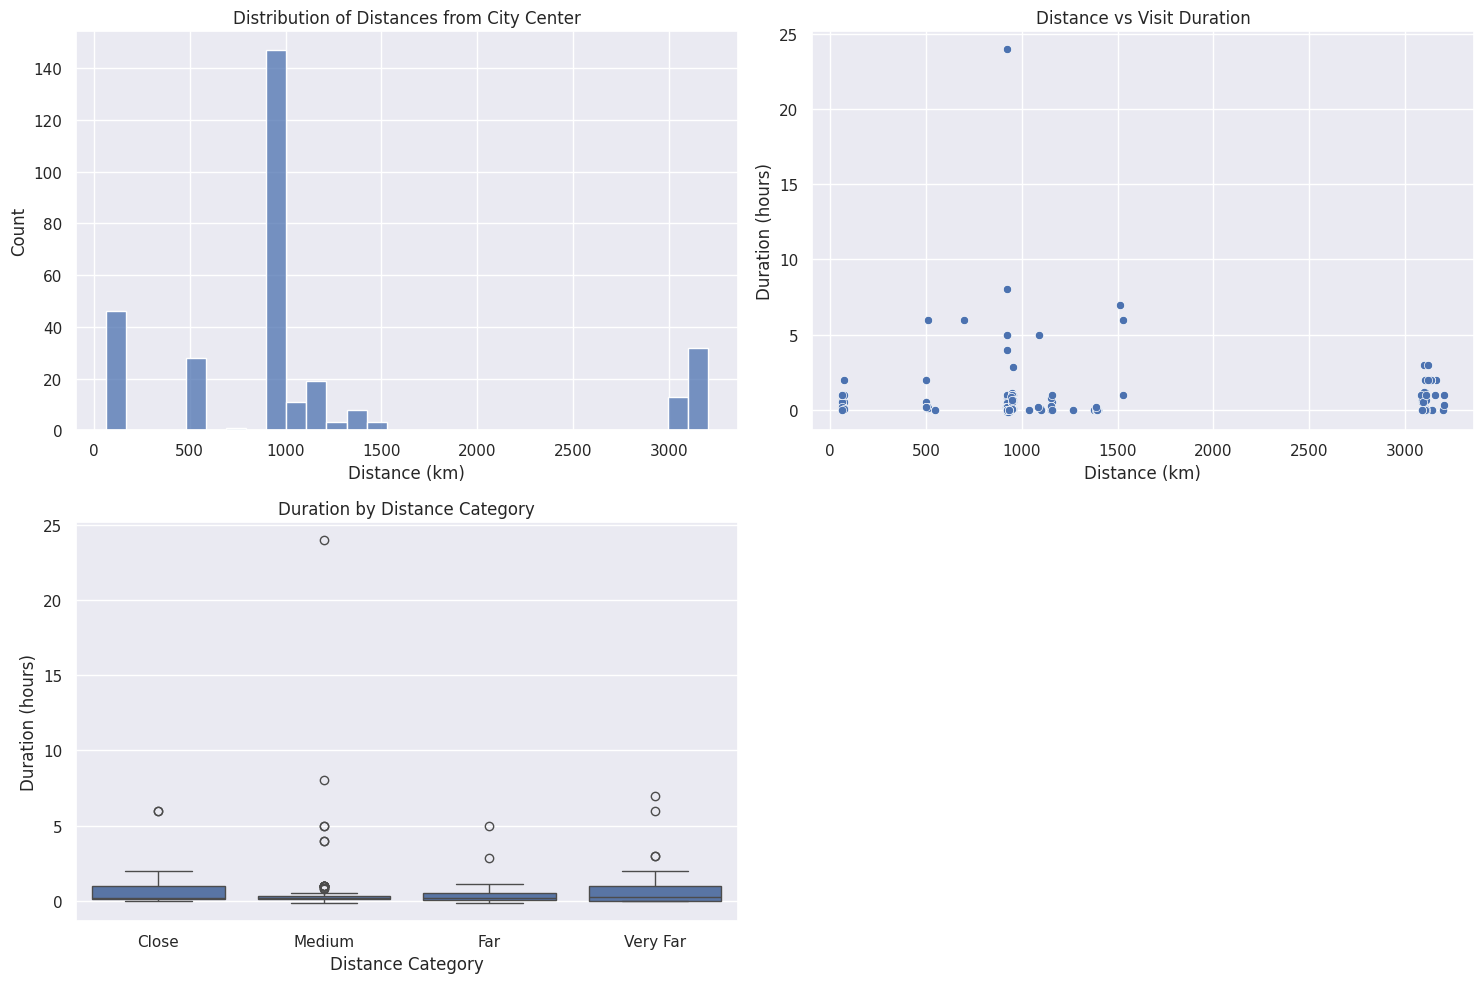


=== Distance Analysis ===
Average distance from center: 1120.74 km
Maximum distance: 3202.11 km

Correlation between distance and duration: 0.06


In [65]:
# Run Spatial Analysis
print("Running Spatial Analysis...")
spatial_analyzer = SpatialAnalyzer(df)
spatial_analyzer.analyze_spatial_patterns()

# 📈 Pattern Detection and Time Series Analysis
This section implements advanced pattern recognition and time series analysis techniques.

In [66]:
class PatternDetector:
    """Advanced pattern detection and analysis"""
    def __init__(self, df):
        self.df = df
        self.config = SystemConfig()

    def detect_patterns(self):
        """Complete pattern detection pipeline"""
        self.analyze_temporal_patterns()
        self.analyze_sequential_patterns()
        self.detect_anomalies()

In [67]:
def analyze_temporal_patterns(self):
    """Analyze complex temporal patterns"""
    # Resample data to daily frequency
    daily_visits = self.df.groupby(self.df['start_time'].dt.date).size()

    # Create time series visualizations
    fig = plt.figure(figsize=(15, 12))

    # 1. Daily visits trend
    plt.subplot(311)
    daily_visits.plot()
    plt.title('Daily Visit Patterns')
    plt.xlabel('Date')
    plt.ylabel('Number of Visits')

    # 2. Weekly patterns
    weekly_avg = self.df.groupby('day_name').size()
    plt.subplot(312)
    weekly_avg.plot(kind='bar')
    plt.title('Average Visits by Day of Week')
    plt.xticks(rotation=45)

    # 3. Hourly patterns by weekday/weekend
    plt.subplot(313)
    weekday_hourly = self.df[~self.df['is_weekend']].groupby('hour').size()
    weekend_hourly = self.df[self.df['is_weekend']].groupby('hour').size()

    plt.plot(weekday_hourly.index, weekday_hourly.values, label='Weekday')
    plt.plot(weekend_hourly.index, weekend_hourly.values, label='Weekend')
    plt.title('Hourly Patterns: Weekday vs Weekend')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Visits')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print pattern insights
    print("\n=== Temporal Pattern Analysis ===")
    print("Peak Times:")
    print(f"Busiest day of week: {weekly_avg.idxmax()}")
    print(f"Busiest hour (weekday): {weekday_hourly.idxmax()}")
    print(f"Busiest hour (weekend): {weekend_hourly.idxmax()}")

# Add method to class
PatternDetector.analyze_temporal_patterns = analyze_temporal_patterns

In [68]:
def analyze_sequential_patterns(self):
    """Analyze visit sequences and transitions"""
    try:
        # Sort visits by user and time
        sorted_visits = self.df.sort_values(['user_id', 'start_time'])

        # Create park sequences
        current_parks = sorted_visits['park_name'].tolist()
        next_parks = sorted_visits['park_name'].shift(-1).tolist()
        same_user = (sorted_visits['user_id'] == sorted_visits['user_id'].shift(-1)).tolist()

        # Create transition matrix
        transitions = []
        for curr, next_, same in zip(current_parks[:-1], next_parks[:-1], same_user[:-1]):
            if same:  # Only count transitions within the same user
                transitions.append((curr, next_))

        # Convert to DataFrame
        if transitions:
            transition_df = pd.DataFrame(transitions, columns=['From', 'To'])
            transition_matrix = pd.crosstab(transition_df['From'], transition_df['To'])

            # Visualize transitions
            plt.figure(figsize=(12, 8))
            sns.heatmap(transition_matrix.head(10).iloc[:, :10],
                       cmap='YlOrRd',
                       annot=True,
                       fmt='d',
                       cbar_kws={'label': 'Number of Transitions'})
            plt.title('Park Visit Transition Patterns (Top 10 Parks)')
            plt.xlabel('Next Park')
            plt.ylabel('Current Park')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

            # Analyze common sequences
            print("\n=== Sequential Pattern Analysis ===")
            print("Most Common Park Transitions:")
            transition_counts = transition_df.groupby(['From', 'To']).size().sort_values(ascending=False)
            for (park1, park2), count in transition_counts.head().items():
                print(f"{park1} → {park2}: {count} times")
        else:
            print("\nNo sequential patterns found in the data")

    except Exception as e:
        print(f"\nError in sequential pattern analysis: {e}")
        print("Continuing with other analyses...")

# Add method to class
PatternDetector.analyze_sequential_patterns = analyze_sequential_patterns

In [69]:
def detect_anomalies(self):
    """Detect anomalous patterns in visits"""
    # Calculate daily statistics
    daily_stats = self.df.groupby(self.df['start_time'].dt.date).agg({
        'park_name': 'count',
        'duration': ['mean', 'std']
    }).round(2)

    daily_stats.columns = ['visits', 'avg_duration', 'std_duration']

    # Calculate z-scores
    for col in ['visits', 'avg_duration']:
        daily_stats[f'{col}_zscore'] = (daily_stats[col] - daily_stats[col].mean()) / daily_stats[col].std()

    # Plot anomalies
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Visits anomalies
    scatter1 = ax1.scatter(daily_stats.index, daily_stats['visits'],
                          c=abs(daily_stats['visits_zscore']) > 2, cmap='coolwarm')
    ax1.set_title('Visit Count Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Visits')

    # Duration anomalies
    scatter2 = ax2.scatter(daily_stats.index, daily_stats['avg_duration'],
                          c=abs(daily_stats['avg_duration_zscore']) > 2, cmap='coolwarm')
    ax2.set_title('Average Duration Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Average Duration (hours)')

    plt.tight_layout()
    plt.show()

    # Print anomaly statistics
    print("\n=== Anomaly Detection ===")
    visit_anomalies = daily_stats[abs(daily_stats['visits_zscore']) > 2]
    duration_anomalies = daily_stats[abs(daily_stats['avg_duration_zscore']) > 2]

    print("\nUnusual Visit Count Days:")
    for date, row in visit_anomalies.iterrows():
        print(f"{date}: {row['visits']} visits (z-score: {row['visits_zscore']:.2f})")

    print("\nUnusual Duration Days:")
    for date, row in duration_anomalies.iterrows():
        print(f"{date}: {row['avg_duration']:.2f} hours (z-score: {row['avg_duration_zscore']:.2f})")

# Add method to class
PatternDetector.detect_anomalies = detect_anomalies

Running Pattern Detection Analysis...


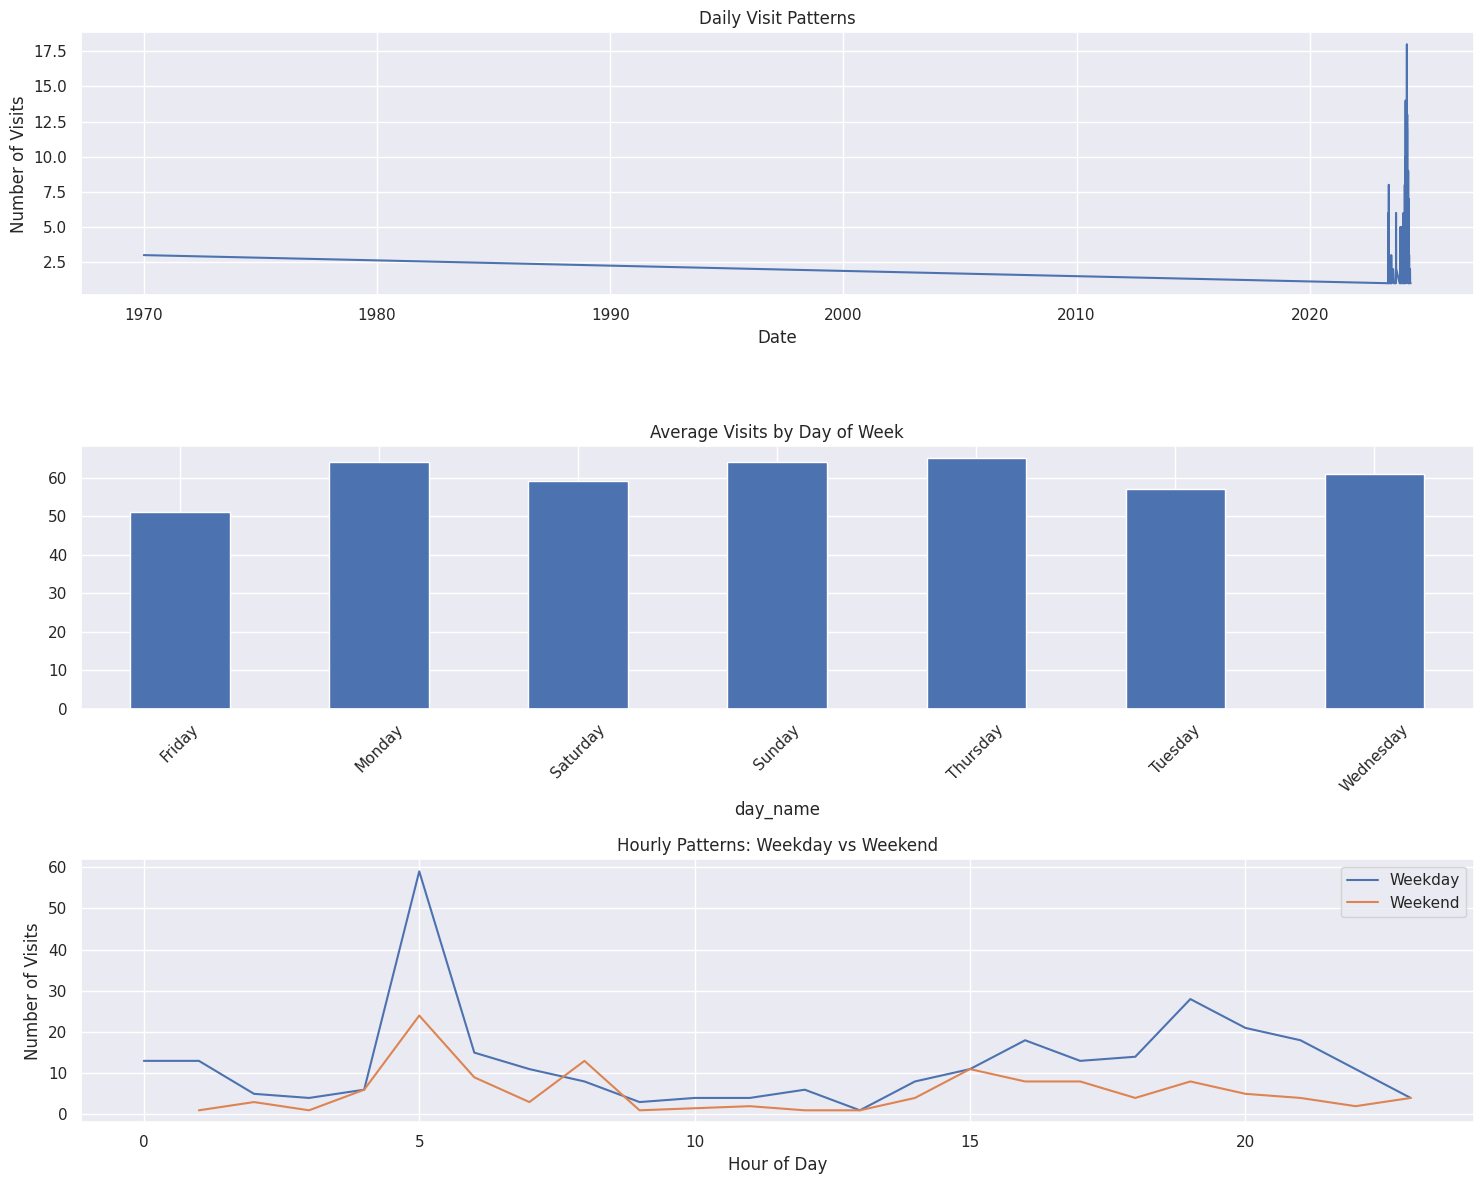


=== Temporal Pattern Analysis ===
Peak Times:
Busiest day of week: Thursday
Busiest hour (weekday): 5
Busiest hour (weekend): 5


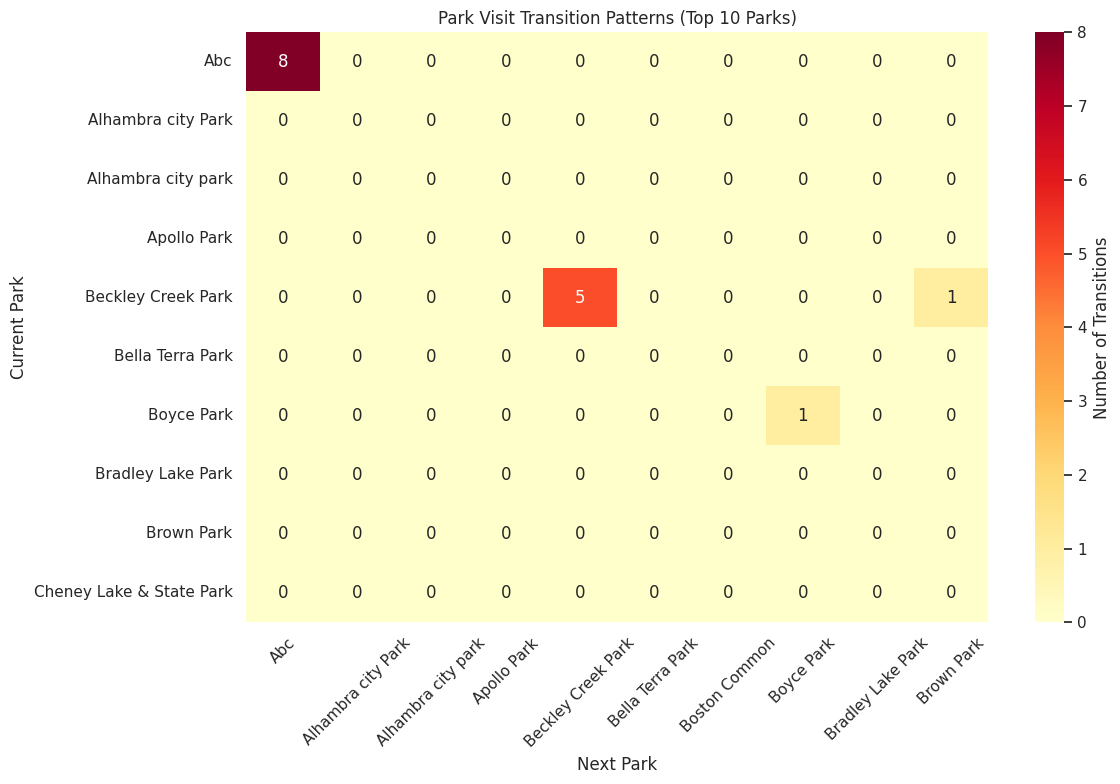


=== Sequential Pattern Analysis ===
Most Common Park Transitions:
Test → Test: 15 times
Mercer Meadows Maidenhead Trail → Mercer Meadows Maidenhead Trail: 13 times
Trenton Recreation Department → Trenton Recreation Department: 12 times
Thompson Park → Thompson Park: 10 times
Mercer Meadows Pole Farm → Mercer Meadows Pole Farm: 9 times


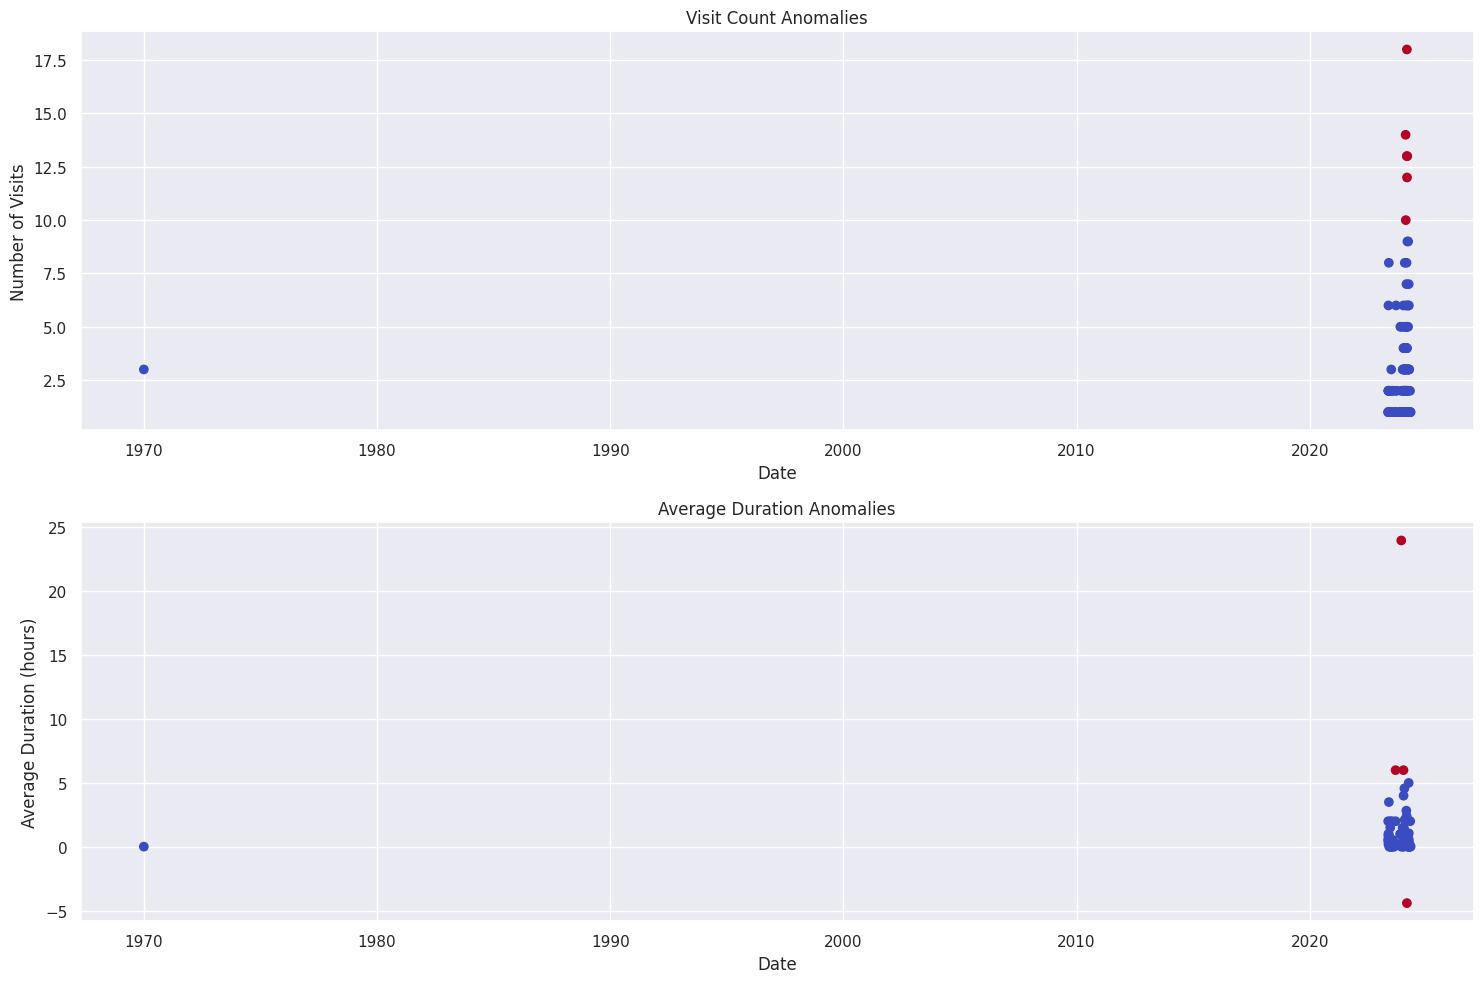


=== Anomaly Detection ===

Unusual Visit Count Days:
2024-02-11: 14.0 visits (z-score: 3.56)
2024-02-14: 10.0 visits (z-score: 2.22)
2024-03-01: 13.0 visits (z-score: 3.23)
2024-03-02: 18.0 visits (z-score: 4.90)
2024-03-04: 12.0 visits (z-score: 2.89)
2024-03-07: 13.0 visits (z-score: 3.23)

Unusual Duration Days:
2023-09-07: 6.00 hours (z-score: 2.14)
2023-12-05: 23.98 hours (z-score: 9.64)
2024-01-09: 6.00 hours (z-score: 2.14)
2024-03-02: -4.41 hours (z-score: -2.21)


In [70]:
# Run Pattern Detection
print("Running Pattern Detection Analysis...")
pattern_detector = PatternDetector(df)
pattern_detector.detect_patterns()

# 🤖 Machine Learning Models
This section implements predictive models for visit duration and pattern prediction.

In [71]:
class ParkMLModels:
    """Comprehensive machine learning models"""
    def __init__(self, df):
        self.df = df
        self.config = SystemConfig()
        self.models = {}
        self.results = {}

    def prepare_data(self):
        """Prepare data for modeling"""
        print("Preparing data for modeling...")

        # Create feature set
        features = self.df.copy()

        # Create dummy variables for categorical columns
        categorical_cols = ['day_name', 'month_name', 'park_name', 'city']
        for col in categorical_cols:
            dummies = pd.get_dummies(features[col], prefix=col)
            features = pd.concat([features, dummies], axis=1)

        # Select numerical features
        numerical_cols = ['hour', 'is_weekend', 'visit_count', 'unique_parks', 'avg_duration']

        # Combine all features
        feature_cols = numerical_cols + [col for col in features.columns
                                       if any(col.startswith(prefix)
                                            for prefix in [f"{cat}_" for cat in categorical_cols])]

        self.X = features[feature_cols]

        # Prepare target variables
        self.y_duration = features['duration']

        # Scale features
        self.scaler = preprocessing.StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.X)
        self.X_scaled = pd.DataFrame(self.X_scaled, columns=self.X.columns)

        print(f"Prepared {len(feature_cols)} features for modeling")
        return self.X_scaled, self.y_duration

In [72]:
def train_duration_model(self):
    """Train model to predict visit duration"""
    print("\nTraining duration prediction model...")

    # Split data
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        self.X_scaled, self.y_duration,
        test_size=self.config.TEST_SIZE,
        random_state=self.config.RANDOM_STATE
    )

    # Train different models
    models = {
        'random_forest': ensemble.RandomForestRegressor(
            n_estimators=100,
            random_state=self.config.RANDOM_STATE
        ),
        'gradient_boost': ensemble.GradientBoostingRegressor(
            n_estimators=100,
            random_state=self.config.RANDOM_STATE
        )
    }

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Evaluate
        mse = metrics.mean_squared_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)

        # Store results
        self.results[name] = {
            'model': model,
            'mse': mse,
            'r2': r2,
            'feature_importance': pd.DataFrame({
                'feature': self.X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
        }

        print(f"Model performance - MSE: {mse:.4f}, R2: {r2:.4f}")

# Add method to class
ParkMLModels.train_duration_model = train_duration_model

In [73]:
def analyze_results(self):
    """Analyze and visualize model results"""
    print("\nAnalyzing model results...")

    # Plot feature importance
    plt.figure(figsize=(15, 10))

    for i, (name, result) in enumerate(self.results.items()):
        plt.subplot(2, 1, i+1)

        # Get top 10 features
        feature_imp = result['feature_importance'].head(10)

        # Create bar plot
        sns.barplot(x='importance', y='feature', data=feature_imp)
        plt.title(f'Top 10 Important Features - {name}')
        plt.xlabel('Feature Importance')

    plt.tight_layout()
    plt.show()

    # Print model comparisons
    print("\n=== Model Performance Comparison ===")
    for name, result in self.results.items():
        print(f"\n{name}:")
        print(f"MSE: {result['mse']:.4f}")
        print(f"R2 Score: {result['r2']:.4f}")
        print("\nTop 5 Important Features:")
        print(result['feature_importance'].head())

# Add method to class
ParkMLModels.analyze_results = analyze_results

In [74]:
def generate_predictions(self):
    """Generate example predictions"""
    print("\nGenerating example predictions...")

    # Get best model based on R2 score
    best_model_name = max(self.results.items(),
                         key=lambda x: x[1]['r2'])[0]
    best_model = self.results[best_model_name]['model']

    # Get sample data points
    sample_data = self.X_scaled.sample(5, random_state=self.config.RANDOM_STATE)

    # Make predictions
    predictions = best_model.predict(sample_data)

    # Display results
    print(f"\nExample predictions using {best_model_name}:")
    for i, (idx, row) in enumerate(sample_data.iterrows()):
        print(f"\nSample {i+1}:")
        print(f"Predicted duration: {predictions[i]:.2f} hours")
        print(f"Actual duration: {self.y_duration[idx]:.2f} hours")

        # Get some context about this visit
        original_row = self.df.loc[idx]
        print(f"Park: {original_row['park_name']}")
        print(f"Day: {original_row['day_name']}")
        print(f"Hour: {original_row['hour']}:00")

# Add method to class
ParkMLModels.generate_predictions = generate_predictions

Running Machine Learning Analysis...
Preparing data for modeling...
Prepared 197 features for modeling

Training duration prediction model...

Training random_forest...
Model performance - MSE: 0.8022, R2: 0.8323

Training gradient_boost...
Model performance - MSE: 0.7796, R2: 0.8370

Analyzing model results...


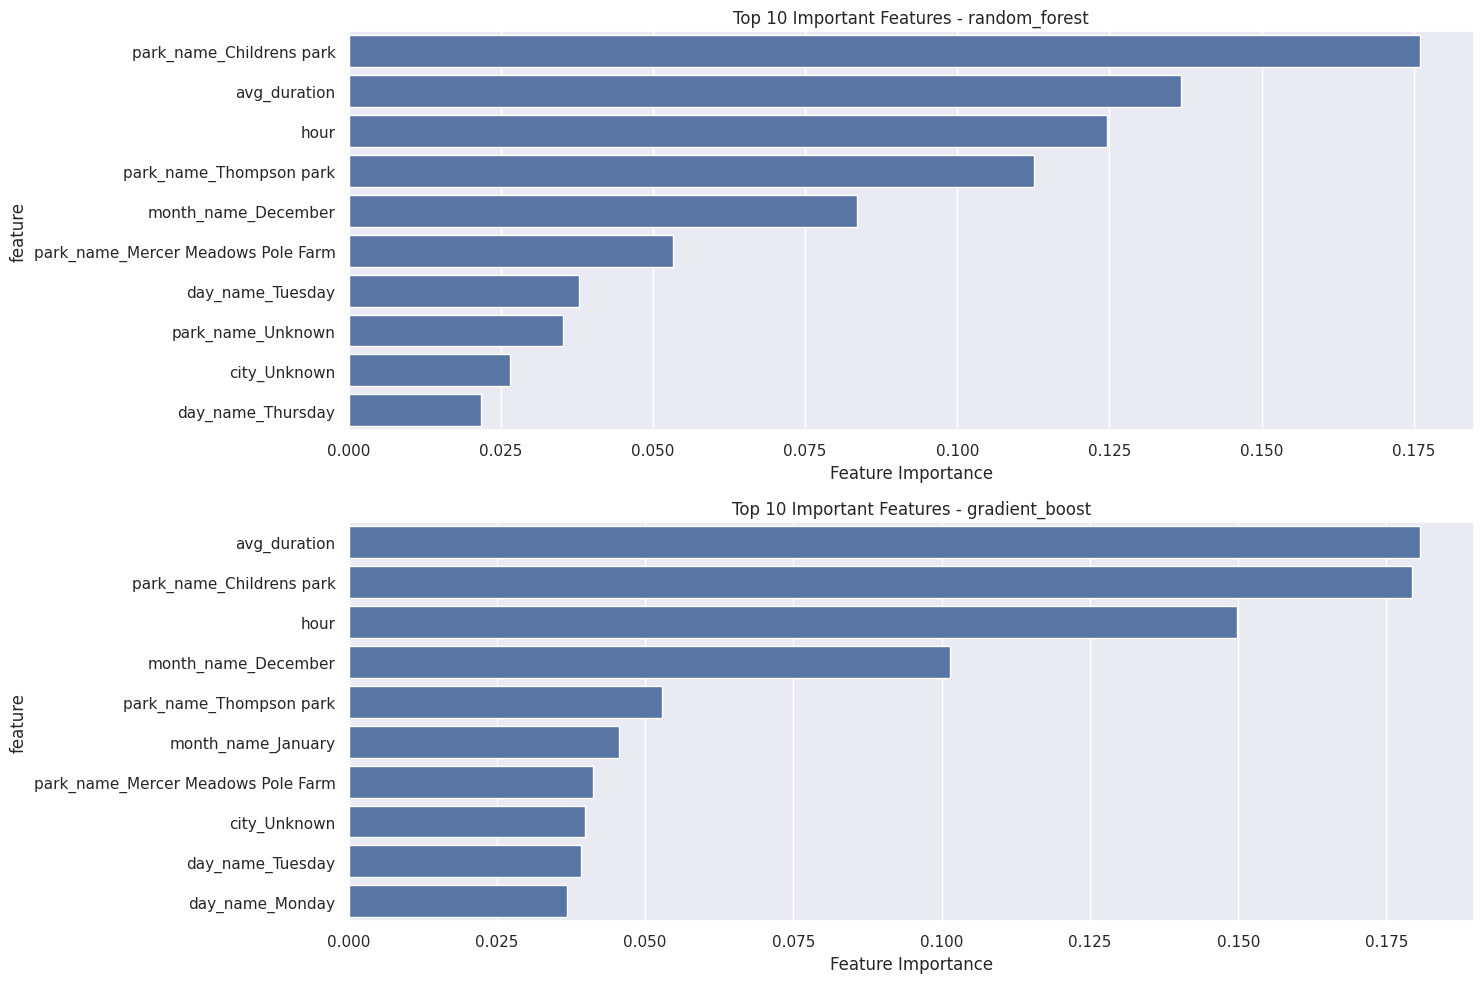


=== Model Performance Comparison ===

random_forest:
MSE: 0.8022
R2 Score: 0.8323

Top 5 Important Features:
                      feature  importance
37   park_name_Childrens park    0.176085
4                avg_duration    0.136737
0                        hour    0.124516
118   park_name_Thompson park    0.112570
14        month_name_December    0.083566

gradient_boost:
MSE: 0.7796
R2 Score: 0.8370

Top 5 Important Features:
                      feature  importance
4                avg_duration    0.180722
37   park_name_Childrens park    0.179364
0                        hour    0.149817
14        month_name_December    0.101397
118   park_name_Thompson park    0.052850

Generating example predictions...

Example predictions using gradient_boost:

Sample 1:
Predicted duration: 0.85 hours
Actual duration: 0.50 hours
Park: Kalithea Park
Day: Wednesday
Hour: 0:00

Sample 2:
Predicted duration: -4.96 hours
Actual duration: -5.88 hours
Park: Unknown
Day: Saturday
Hour: 8:00

Sample 

In [75]:
# Run Machine Learning Analysis
print("Running Machine Learning Analysis...")
ml_models = ParkMLModels(df)
ml_models.prepare_data()
ml_models.train_duration_model()
ml_models.analyze_results()
ml_models.generate_predictions()

# 📊 Interactive Visualization Dashboard
This section creates comprehensive interactive visualizations for the entire analysis.

In [76]:
class VisualizationSystem:
    """Comprehensive visualization system for park analysis"""
    def __init__(self, df, ml_pipeline=None):
        self.df = df
        self.ml_pipeline = ml_pipeline
        self.config = SystemConfig()

    def create_dashboard(self):
        """Create complete interactive dashboard"""
        print("Generating Interactive Dashboards...")
        self.temporal_dashboard()
        self.spatial_dashboard()
        self.user_dashboard()
        self.prediction_dashboard()

In [77]:
def temporal_dashboard(self):
    """Create temporal analysis dashboard"""
    print("\nGenerating Temporal Dashboard...")

    # Create subplot layout
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Hourly Visit Pattern',
            'Weekly Visit Pattern',
            'Monthly Trend',
            'Visit Duration Distribution'
        )
    )

    # 1. Hourly pattern
    hourly_visits = self.df.groupby('hour')['park_name'].count()
    fig.add_trace(
        go.Scatter(x=hourly_visits.index, y=hourly_visits.values,
                  mode='lines+markers', name='Hourly Visits'),
        row=1, col=1
    )

    # 2. Weekly pattern
    weekly_visits = self.df.groupby('day_name')['park_name'].count()
    fig.add_trace(
        go.Bar(x=weekly_visits.index, y=weekly_visits.values,
              name='Weekly Visits'),
        row=1, col=2
    )

    # 3. Monthly trend
    monthly_visits = self.df.groupby('month_name')['park_name'].count()
    fig.add_trace(
        go.Scatter(x=monthly_visits.index, y=monthly_visits.values,
                  mode='lines+markers', name='Monthly Trend'),
        row=2, col=1
    )

    # 4. Duration distribution
    fig.add_trace(
        go.Histogram(x=self.df['duration'], name='Visit Duration'),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        height=800,
        title_text="Temporal Analysis Dashboard",
        showlegend=False
    )

    fig.show()

# Add method to class
VisualizationSystem.temporal_dashboard = temporal_dashboard

In [78]:
def spatial_dashboard(self):
    """Create spatial analysis dashboard"""
    print("\nGenerating Spatial Dashboard...")

    # Filter valid coordinates
    df_with_coords = self.df.dropna(subset=['latitude', 'longitude'])

    if len(df_with_coords) > 0:
        # Create figure
        fig = go.Figure()

        # Add scatter plot for park locations
        fig.add_trace(go.Scattermapbox(
            lat=df_with_coords['latitude'],
            lon=df_with_coords['longitude'],
            mode='markers',
            marker=dict(
                size=10,
                color=df_with_coords['visit_count'],
                colorscale='Viridis',
                showscale=True
            ),
            text=df_with_coords['park_name'],
            hoverinfo='text'
        ))

        # Update layout
        fig.update_layout(
            title='Park Locations and Visit Frequency',
            mapbox=dict(
                style="carto-positron",
                zoom=10,
                center=dict(
                    lat=df_with_coords['latitude'].mean(),
                    lon=df_with_coords['longitude'].mean()
                )
            ),
            height=600
        )

        fig.show()
    else:
        print("No valid coordinate data for spatial dashboard")

# Add method to class
VisualizationSystem.spatial_dashboard = spatial_dashboard

In [79]:
def user_dashboard(self):
    """Create user behavior dashboard"""
    print("\nGenerating User Behavior Dashboard...")

    # Create subplot layout
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'User Visit Patterns',
            'Visit Duration by User',
            'User Segments',
            'User Activity Timeline'
        )
    )

    # 1. User visit patterns
    user_visits = self.df.groupby('user_id')['park_name'].count().sort_values(ascending=False)
    fig.add_trace(
        go.Bar(x=user_visits.index, y=user_visits.values,
              name='Visits per User'),
        row=1, col=1
    )

    # 2. Visit duration by user
    user_duration = self.df.groupby('user_id')['duration'].mean().sort_values(ascending=False)
    fig.add_trace(
        go.Bar(x=user_duration.index, y=user_duration.values,
              name='Average Duration'),
        row=1, col=2
    )

    # 3. User segments scatter
    fig.add_trace(
        go.Scatter(
            x=self.df['visit_count'],
            y=self.df['avg_duration'],
            mode='markers',
            marker=dict(
                color=self.df['unique_parks'],
                colorscale='Viridis',
                showscale=True
            ),
            name='User Segments'
        ),
        row=2, col=1
    )

    # 4. User activity timeline
    timeline = self.df.groupby('start_time').size()
    fig.add_trace(
        go.Scatter(x=timeline.index, y=timeline.values,
                  mode='lines', name='Activity Timeline'),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        height=800,
        title_text="User Behavior Dashboard",
        showlegend=False
    )

    fig.show()

# Add method to class
VisualizationSystem.user_dashboard = user_dashboard

In [80]:
def prediction_dashboard(self):
    """Create prediction analysis dashboard"""
    print("\nGenerating Prediction Dashboard...")

    if self.ml_pipeline and hasattr(self.ml_pipeline, 'results'):
        # Get the best model results
        best_model = max(self.ml_pipeline.results.items(),
                        key=lambda x: x[1]['r2'])[1]

        # Create subplot layout
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Feature Importance',
                'Prediction vs Actual',
                'Prediction Error Distribution',
                'Model Performance by Category'
            )
        )

        # 1. Feature importance
        feature_imp = best_model['feature_importance'].head(10)
        fig.add_trace(
            go.Bar(
                x=feature_imp['importance'],
                y=feature_imp['feature'],
                orientation='h',
                name='Feature Importance'
            ),
            row=1, col=1
        )

        # 2. Prediction vs Actual
        predictions = best_model['model'].predict(self.ml_pipeline.X_scaled)
        fig.add_trace(
            go.Scatter(
                x=self.df['duration'],
                y=predictions,
                mode='markers',
                name='Predictions'
            ),
            row=1, col=2
        )

        # 3. Error distribution
        errors = self.df['duration'] - predictions
        fig.add_trace(
            go.Histogram(x=errors, name='Prediction Error'),
            row=2, col=1
        )

        # Update layout
        fig.update_layout(
            height=800,
            title_text="Prediction Analysis Dashboard",
            showlegend=False
        )

        fig.show()
    else:
        print("ML pipeline results not available for prediction dashboard")

# Add method to class
VisualizationSystem.prediction_dashboard = prediction_dashboard

In [81]:
# Create and run visualization system
print("Generating Complete Visualization Dashboard...")
visualization_system = VisualizationSystem(df, ml_models)
visualization_system.create_dashboard()

Generating Complete Visualization Dashboard...
Generating Interactive Dashboards...

Generating Temporal Dashboard...



Generating Spatial Dashboard...



Generating User Behavior Dashboard...



Generating Prediction Dashboard...


# 📑 Results Export and Report Generation
This section saves the analysis results and generates comprehensive reports.

In [83]:
class ReportGenerator:
    """Generate and save comprehensive analysis reports"""
    def __init__(self, df, ml_models, visualization_system):
        self.df = df
        self.ml_models = ml_models
        self.visualization_system = visualization_system
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    def generate_complete_report(self):
        """Generate all reports and save results"""
        print("Generating Complete Analysis Report...")
        self.save_analysis_summary()
        self.save_model_results()
        self.generate_insights()
        self.export_visualizations()

In [89]:
def save_analysis_summary(self):
    """Save basic analysis summary"""
    print("\nSaving Analysis Summary...")

    # Function to convert numpy types to native Python types
    def convert_to_native(obj):
        if isinstance(obj, (np.integer, np.floating)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj

    summary = {
        "dataset_info": {
            "total_records": int(len(self.df)),
            "unique_parks": int(self.df['park_name'].nunique()),
            "unique_users": int(self.df['user_id'].nunique()),
            "date_range": {
                "start": str(self.df['start_time'].min()),
                "end": str(self.df['end_time'].max())
            }
        },
        "temporal_analysis": {
            "busiest_day": str(self.df.groupby('day_name')['park_name'].count().idxmax()),
            "busiest_hour": int(self.df.groupby('hour')['park_name'].count().idxmax()),
            "busiest_month": str(self.df.groupby('month_name')['park_name'].count().idxmax()),
            "avg_duration": float(self.df['duration'].mean())
        },
        "location_analysis": {
            "most_visited_park": str(self.df['park_name'].mode()[0]),
            "cities_covered": int(self.df['city'].nunique()),
            "parks_with_coordinates": int(self.df.dropna(subset=['latitude', 'longitude'])['park_name'].nunique())
        },
        "user_analysis": {
            "avg_visits_per_user": float(self.df['visit_count'].mean()),
            "avg_parks_per_user": float(self.df['unique_parks'].mean()),
            "avg_duration_per_user": float(self.df['avg_duration'].mean())
        }
    }

    # Convert all numpy types to native Python types
    summary = {k: {k2: convert_to_native(v2) for k2, v2 in v.items()}
              if isinstance(v, dict) else convert_to_native(v)
              for k, v in summary.items()}

    # Save to JSON
    try:
        with open(f'analysis_summary_{self.timestamp}.json', 'w') as f:
            json.dump(summary, f, indent=4)
        print(f"Analysis summary saved to: analysis_summary_{self.timestamp}.json")
    except Exception as e:
        print(f"Error saving analysis summary: {e}")
        print("Continuing with other exports...")

# Add method to class
ReportGenerator.save_analysis_summary = save_analysis_summary

In [90]:
def save_model_results(self):
    """Save machine learning model results"""
    print("\nSaving Model Results...")

    if hasattr(self.ml_models, 'results'):
        model_results = {}

        for model_name, results in self.ml_models.results.items():
            model_results[model_name] = {
                "performance": {
                    "mse": float(results['mse']),
                    "r2": float(results['r2'])
                },
                "top_features": results['feature_importance'].head(10).to_dict('records')
            }

        # Save to JSON
        with open(f'model_results_{self.timestamp}.json', 'w') as f:
            json.dump(model_results, f, indent=4)

        print(f"Model results saved to: model_results_{self.timestamp}.json")
    else:
        print("No model results available to save")

# Add method to class
ReportGenerator.save_model_results = save_model_results

In [91]:
def generate_insights(self):
    """Generate key insights from the analysis"""
    print("\nGenerating Key Insights...")

    insights = {
        "visit_patterns": {
            "peak_times": {
                "day": self.df.groupby('day_name')['park_name'].count().idxmax(),
                "hour": str(self.df.groupby('hour')['park_name'].count().idxmax()) + ":00",
                "month": self.df.groupby('month_name')['park_name'].count().idxmax()
            },
            "duration_patterns": {
                "avg_duration": f"{self.df['duration'].mean():.2f} hours",
                "typical_visit_range": f"{self.df['duration'].quantile(0.25):.2f} - {self.df['duration'].quantile(0.75):.2f} hours"
            }
        },
        "location_insights": {
            "popular_parks": self.df['park_name'].value_counts().head(5).to_dict(),
            "city_distribution": self.df['city'].value_counts().head(5).to_dict()
        },
        "user_insights": {
            "engagement_levels": {
                "high_frequency_users": int(self.df[self.df['visit_count'] > self.df['visit_count'].quantile(0.75)]['user_id'].nunique()),
                "avg_visits_per_user": float(self.df['visit_count'].mean())
            }
        }
    }

    # Save insights to JSON
    with open(f'analysis_insights_{self.timestamp}.json', 'w') as f:
        json.dump(insights, f, indent=4)

    print(f"Analysis insights saved to: analysis_insights_{self.timestamp}.json")

# Add method to class
ReportGenerator.generate_insights = generate_insights

In [92]:
def export_visualizations(self):
    """Export visualization data for external use"""
    print("\nExporting Visualization Data...")

    # Create visualizations directory
    import os
    viz_dir = f'visualizations_{self.timestamp}'
    os.makedirs(viz_dir, exist_ok=True)

    # Save temporal data
    temporal_data = {
        'hourly_pattern': self.df.groupby('hour')['park_name'].count().to_dict(),
        'daily_pattern': self.df.groupby('day_name')['park_name'].count().to_dict(),
        'monthly_pattern': self.df.groupby('month_name')['park_name'].count().to_dict()
    }

    with open(f'{viz_dir}/temporal_data.json', 'w') as f:
        json.dump(temporal_data, f, indent=4)

    # Save location data (excluding sensitive information)
    location_data = self.df.groupby('park_name').agg({
        'visit_count': 'mean',
        'duration': 'mean'
    }).round(2).to_dict()

    with open(f'{viz_dir}/location_data.json', 'w') as f:
        json.dump(location_data, f, indent=4)

    print(f"Visualization data exported to: {viz_dir}/")

# Add method to class
ReportGenerator.export_visualizations = export_visualizations

In [94]:
# Generate complete report
print("Generating Final Reports and Exports...")
report_generator = ReportGenerator(df, ml_models, visualization_system)
report_generator.generate_complete_report()

Generating Final Reports and Exports...
Generating Complete Analysis Report...

Saving Analysis Summary...
Analysis summary saved to: analysis_summary_20241118_045248.json

Saving Model Results...
Model results saved to: model_results_20241118_045248.json

Generating Key Insights...
Analysis insights saved to: analysis_insights_20241118_045248.json

Exporting Visualization Data...
Visualization data exported to: visualizations_20241118_045248/


In [95]:
# Function to read and display JSON results
def display_analysis_results():
    """Read and display all analysis results"""
    import glob
    import json

    # Find all JSON files from our analysis
    json_files = glob.glob('analysis_*.json')

    print("=== Available Analysis Files ===")
    for i, file in enumerate(json_files, 1):
        print(f"{i}. {file}")

    # Read and display each file
    print("\n=== Analysis Results ===")
    for file in json_files:
        print(f"\n📊 Contents of {file}:")
        print("-" * 50)
        try:
            with open(file, 'r') as f:
                data = json.load(f)

            # Display each section of the results
            for section, content in data.items():
                print(f"\n{section.upper()}:")
                if isinstance(content, dict):
                    for key, value in content.items():
                        print(f"  {key}: {value}")
                else:
                    print(f"  {content}")
        except Exception as e:
            print(f"Error reading {file}: {e}")

# Display all results
display_analysis_results()

=== Available Analysis Files ===
1. analysis_insights_20241118_045008.json
2. analysis_summary_20241118_044911.json
3. analysis_summary_20241118_045008.json
4. analysis_insights_20241118_045248.json
5. analysis_summary_20241118_045248.json

=== Analysis Results ===

📊 Contents of analysis_insights_20241118_045008.json:
--------------------------------------------------

VISIT_PATTERNS:
  peak_times: {'day': 'Thursday', 'hour': '5:00', 'month': 'March'}
  duration_patterns: {'avg_duration': '0.47 hours', 'typical_visit_range': '0.01 - 0.67 hours'}

LOCATION_INSIGHTS:
  popular_parks: {'Mercer Meadows Maidenhead Trail': 35, 'Mercer Meadows Pole Farm': 28, 'Trenton Recreation Department': 22, 'Test': 19, 'Thompson Park': 18}
  city_distribution: {'Trenton': 43, 'Louisville': 42, 'Lawrenceville': 35, 'None': 32, 'Lawrence': 30}

USER_INSIGHTS:
  engagement_levels: {'high_frequency_users': 1, 'avg_visits_per_user': 21.902612826603324}

📊 Contents of analysis_summary_20241118_044911.json:
--

In [96]:
# Function to create a summary dashboard of key metrics
def display_key_metrics():
    """Display key metrics in a formatted way"""
    print("=== Key Analysis Metrics ===")
    print("\n1. Dataset Overview")
    print("-" * 20)
    print(f"Total Records: {len(df)}")
    print(f"Unique Parks: {df['park_name'].nunique()}")
    print(f"Unique Users: {df['user_id'].nunique()}")
    print(f"Date Range: {df['start_time'].min().date()} to {df['end_time'].max().date()}")

    print("\n2. Visit Patterns")
    print("-" * 20)
    print(f"Average Visit Duration: {df['duration'].mean():.2f} hours")
    print(f"Most Common Day: {df.groupby('day_name')['park_name'].count().idxmax()}")
    print(f"Most Common Hour: {df.groupby('hour')['park_name'].count().idxmax()}:00")

    print("\n3. Top Parks")
    print("-" * 20)
    top_parks = df['park_name'].value_counts().head(5)
    for park, count in top_parks.items():
        print(f"{park}: {count} visits")

    print("\n4. User Activity")
    print("-" * 20)
    print(f"Average Visits per User: {df['visit_count'].mean():.2f}")
    print(f"Average Parks per User: {df['unique_parks'].mean():.2f}")

# Display key metrics
display_key_metrics()

=== Key Analysis Metrics ===

1. Dataset Overview
--------------------
Total Records: 421
Unique Parks: 109
Unique Users: 50
Date Range: 1970-01-01 to 2024-04-30

2. Visit Patterns
--------------------
Average Visit Duration: 0.47 hours
Most Common Day: Thursday
Most Common Hour: 5:00

3. Top Parks
--------------------
Mercer Meadows Maidenhead Trail: 35 visits
Mercer Meadows Pole Farm: 28 visits
Trenton Recreation Department: 22 visits
Test: 19 visits
Thompson Park: 18 visits

4. User Activity
--------------------
Average Visits per User: 21.90
Average Parks per User: 7.26


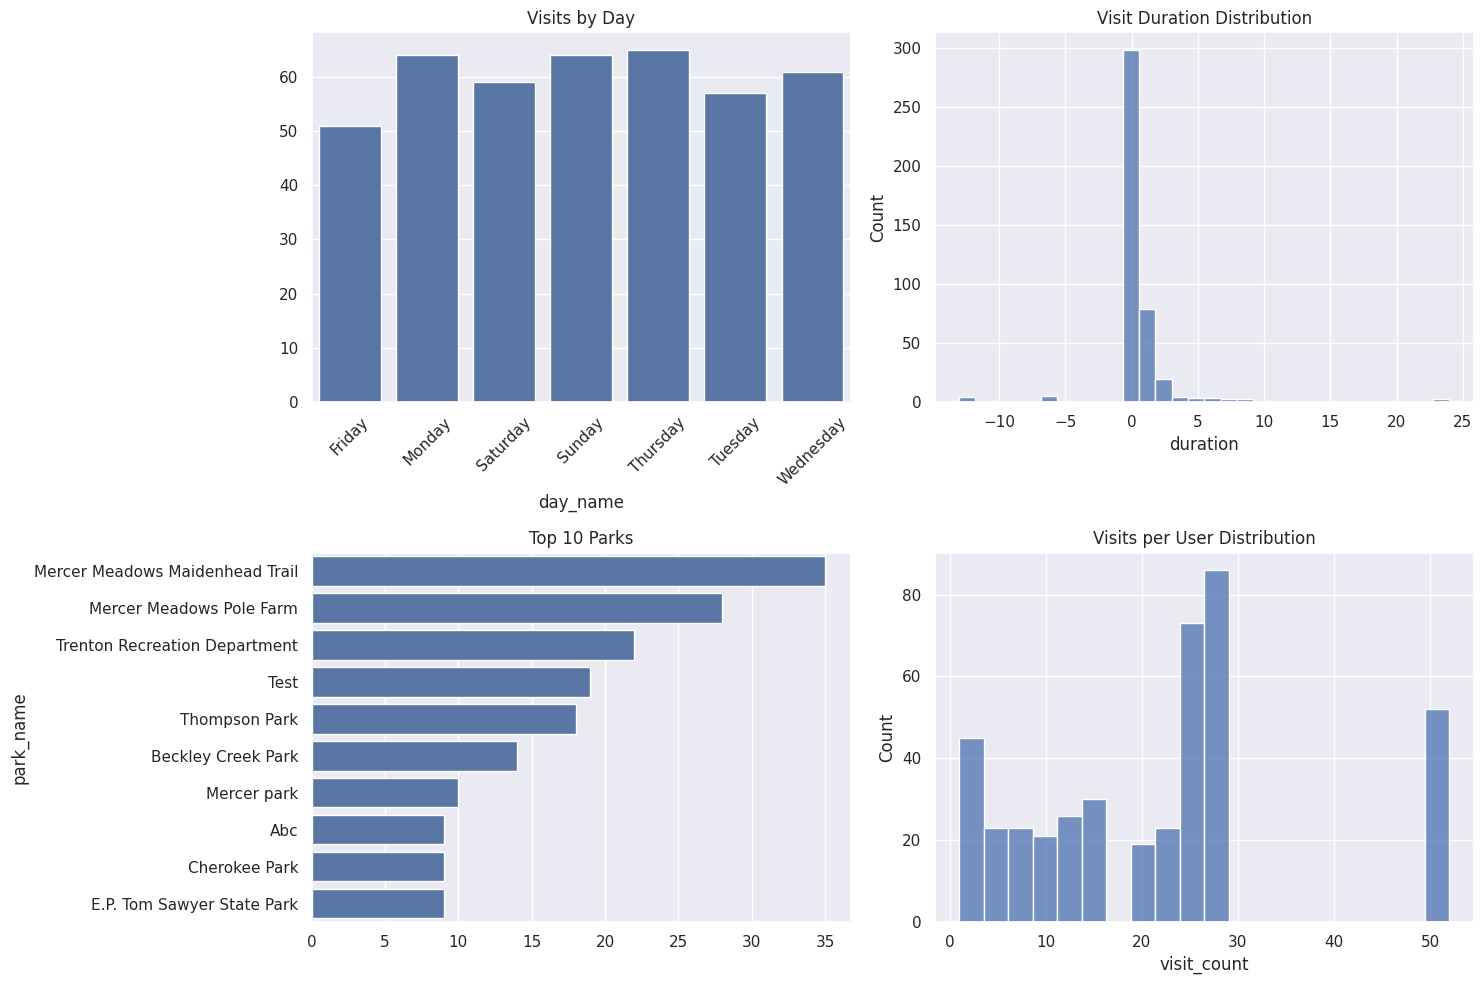

In [97]:
# Function to visualize key results
def plot_key_results():
    """Create summary visualizations"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Visit patterns by day
    sns.barplot(
        x=df.groupby('day_name')['park_name'].count().index,
        y=df.groupby('day_name')['park_name'].count().values,
        ax=axes[0,0]
    )
    axes[0,0].set_title('Visits by Day')
    axes[0,0].tick_params(axis='x', rotation=45)

    # 2. Visit duration distribution
    sns.histplot(data=df, x='duration', bins=30, ax=axes[0,1])
    axes[0,1].set_title('Visit Duration Distribution')

    # 3. Top parks
    top_parks = df['park_name'].value_counts().head(10)
    sns.barplot(x=top_parks.values, y=top_parks.index, ax=axes[1,0])
    axes[1,0].set_title('Top 10 Parks')

    # 4. User activity
    sns.histplot(data=df, x='visit_count', bins=20, ax=axes[1,1])
    axes[1,1].set_title('Visits per User Distribution')

    plt.tight_layout()
    plt.show()

# Display visualizations
plot_key_results()